In [1]:
import numpy as np
import pandas as pd
import json
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster




In [2]:
class GeoClustering:
    def __init__(self, cluster_method='kmeans'):
        self.cluster_method = cluster_method
        self.model=None
        self.clusters = None
        self.cluster_centers = None
        
    def haversine_distance(self, pt1, pt2):
        R = 6371  # Earth radius in km
        lon1, lat1 = radians(pt1[0]), radians(pt1[1])
        lon2, lat2 = radians(pt2[0]), radians(pt2[1])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        return R * (2 * atan2(sqrt(a), sqrt(1 - a)))

    def load_coordinates(self, source_file=None, destination_file=None, coordinates=None):
        if coordinates is not None:
            return coordinates
        
        coords = []
        if source_file:
            with open(source_file) as f:
                srcdf = pd.read_json(f)
            src_coords = list(zip(srcdf["lon"], srcdf["lat"]))
            coords.extend(src_coords)
        
        if destination_file:
            with open(destination_file) as f:
                destdf = pd.read_json(f)
            dest_coords = list(zip(destdf["lon"], destdf["lat"]))
            coords.extend(dest_coords)
            
        return coords

    def create_clusters_dbscan(self, coordinates, eps_km=5.0, min_samples=6):
        if len(coordinates) < min_samples:
            return [-1] * len(coordinates), []
        
        coords_rad = np.radians([[lat, lon] for lon, lat in coordinates])
        eps_rad = eps_km / 6371.0
        
        dbscan = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine')
        cluster_labels = dbscan.fit_predict(coords_rad)
        
        centers = []
        unique_labels = set(cluster_labels)
        for label in unique_labels:
            if label != -1:
                cluster_points = [coordinates[i] for i, l in enumerate(cluster_labels) if l == label]
                center_lon = sum(p[0] for p in cluster_points) / len(cluster_points)
                center_lat = sum(p[1] for p in cluster_points) / len(cluster_points)
                centers.append((center_lon, center_lat))
        
        return cluster_labels, centers

    def create_clusters_kmeans(self, coordinates, n_clusters=3):
        if len(coordinates) < n_clusters:
            n_clusters = len(coordinates)
        
        coords_array = np.array(coordinates)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(coords_array)
        self.model = kmeans
        self.cluster_centers = [(center[0], center[1]) for center in kmeans.cluster_centers_]
        return cluster_labels, self.cluster_centers


    def create_distance_based_clusters(self, coordinates, max_distance_km=5.0):
        clusters = []
        cluster_labels = [-1] * len(coordinates)
        current_cluster = 0
        
        for i, coord in enumerate(coordinates):
            if cluster_labels[i] != -1:
                continue
            cluster_points = [i]
            cluster_labels[i] = current_cluster
            for j, other_coord in enumerate(coordinates):
                if i != j and cluster_labels[j] == -1:
                    distance = self.haversine_distance(coord, other_coord)
                    if distance <= max_distance_km:
                        cluster_points.append(j)
                        cluster_labels[j] = current_cluster
            clusters.append(cluster_points)
            current_cluster += 1
        
        centers = []
        for cluster_indices in clusters:
            cluster_coords = [coordinates[i] for i in cluster_indices]
            center_lon = sum(p[0] for p in cluster_coords) / len(cluster_coords)
            center_lat = sum(p[1] for p in cluster_coords) / len(cluster_coords)
            centers.append((center_lon, center_lat))
        return cluster_labels, centers

    def cluster_coordinates(self, coordinates, **kwargs):
        if self.cluster_method == 'dbscan':
            return self.create_clusters_dbscan(coordinates, **kwargs)
        elif self.cluster_method == 'kmeans':
            if kwargs.pop("auto", False):
                return self.auto_kmeans(coordinates, max_k=kwargs.get("max_k", 10))
            else:
                return self.create_clusters_kmeans(coordinates, **kwargs)
        elif self.cluster_method == 'distance':
            return self.create_distance_based_clusters(coordinates, **kwargs)
        else:
            raise ValueError("Unknown clustering method")

    def analyze_clusters(self, coordinates, cluster_labels):
        cluster_info = {}
        unique_labels = set(cluster_labels)
        
        for label in unique_labels:
            label = int(label) if hasattr(label, 'item') else label
            if label == -1:
                cluster_info['noise'] = {
                    'count': sum(1 for l in cluster_labels if int(l) == -1),
                    'points': [coordinates[i] for i, l in enumerate(cluster_labels) if int(l) == -1]
                }
                continue
            
            cluster_points = [coordinates[i] for i, l in enumerate(cluster_labels) if int(l) == label]
            center_lon = sum(p[0] for p in cluster_points) / len(cluster_points)
            center_lat = sum(p[1] for p in cluster_points) / len(cluster_points)
            max_distance = max(
                self.haversine_distance((center_lon, center_lat), point) 
                for point in cluster_points
            )
            cluster_info[f'cluster_{label}'] = {
                'count': len(cluster_points),
                'center': (float(center_lon), float(center_lat)),
                'radius_km': float(max_distance),
                'points': cluster_points
            }
        return cluster_info

    def save_results(self, coordinates, cluster_labels, cluster_centers, output_file='clusters.json'):
        cluster_info = self.analyze_clusters(coordinates, cluster_labels)

        output = {
            'clusters': cluster_info,
            'centers': [{'lon': float(center[0]), 'lat': float(center[1])} for center in cluster_centers],
            'points': [
                {
                    'lon': float(coord[0]), 
                    'lat': float(coord[1]), 
                    'cluster': int(label) if label != -1 else -1
                } 
                for coord, label in zip(coordinates, cluster_labels)
            ],
            'summary': {
                'total_points': len(coordinates),
                'num_clusters': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0),
                'noise_points': sum(1 for l in cluster_labels if l == -1)
            }
        }

        with open(output_file, 'w') as f:
            json.dump(output, f, indent=2)

        return output
    def auto_kmeans(self, coordinates, max_k=10):
        coords_array = np.array(coordinates)
        best_k = 2
        best_score = -1
        best_labels = None
        best_centers = None

        for k in range(2, min(max_k + 1, len(coordinates))):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(coords_array)
            try:
                score = silhouette_score(coords_array, labels)
            except:
                score = -1  # handle degenerate case
            if score > best_score:
                best_k = k
                best_score = score
                best_labels = labels
                best_centers = kmeans.cluster_centers_
                best_model = kmeans

        print(f"Auto-selected k = {best_k} with silhouette score = {best_score:.3f}")
        self.model = best_model
        self.cluster_centers = [(center[0], center[1]) for center in best_centers]
        return best_labels, self.cluster_centers

    def predict_cluster(self, new_coords):
        """
        Assign cluster to new coordinates.
        `new_coords`: List of (lon, lat) tuples.
        Returns: List of cluster labels.
        """
        if self.cluster_method == 'kmeans':
            if self.model is None:
                raise ValueError("Model not trained yet. Call `cluster_coordinates()` first.")
            
            X = np.array(new_coords)
            return self.model.predict(X)

        elif self.cluster_method == 'dbscan':
            # DBSCAN doesn’t support `.predict()` directly
            # You must compare distances to cluster centers or re-cluster
            raise NotImplementedError("DBSCAN does not support direct prediction. Consider KMeans.")

        elif self.cluster_method == 'distance':
            # Assign to closest center if within threshold
            assigned = []
            for coord in new_coords:
                found = -1
                for idx, center in enumerate(self.cluster_centers):
                    if self.haversine_distance(coord, center) <= 5.0:  # or your threshold
                        found = idx
                        break
                assigned.append(found)
            return assigned

        else:
            raise ValueError("Unknown clustering method.")


In [3]:
def load_coordinates(self, source_file=None, destination_file=None, coordinates=None):
        """Load coordinates from JSON files or direct input"""
        if coordinates is not None:
            # Direct coordinate input: [(lon, lat), (lon, lat), ...]
            return coordinates
        
        coords = []
        
        # Load source coordinates if provided
        if source_file:
            with open(source_file) as f:
                srcdf = pd.read_json(f)
            src_coords = list(zip(srcdf["lon"], srcdf["lat"]))
            coords.extend(src_coords)
        
        # Load destination coordinates if provided
        if destination_file:
            with open(destination_file) as f:
                destdf = pd.read_json(f)
            dest_coords = list(zip(destdf["lon"], destdf["lat"]))
            coords.extend(dest_coords)
            
        return coords

In [4]:

# Initialize clustering system
clusterer = GeoClustering(cluster_method='kmeans')  # Choose from 'dbscan', 'kmeans', 'distance'

coordinates = clusterer.load_coordinates(
    source_file="source.json",
    destination_file="destination.json"
)
# Run clustering based on method
if clusterer.cluster_method == 'dbscan':
    cluster_labels, centers = clusterer.cluster_coordinates(
        coordinates, eps_km=2.0, min_samples=2
    )
elif clusterer.cluster_method == 'kmeans':
    cluster_labels, centers = clusterer.cluster_coordinates(
        coordinates,
        auto=True,       
        max_k=15         # Upper limit for K
    )
elif clusterer.cluster_method == 'distance':
    cluster_labels, centers = clusterer.cluster_coordinates(
        coordinates, max_distance_km=5.0
    )


Auto-selected k = 10 with silhouette score = 0.437


In [5]:




cluster_labels, centers = clusterer.cluster_coordinates(
    coordinates,
    auto=True,      
    max_k=10         
)

Auto-selected k = 10 with silhouette score = 0.437


In [6]:
results = clusterer.save_results(coordinates, cluster_labels, centers)
results['summary']

{'total_points': 1286, 'num_clusters': 10, 'noise_points': 0}

In [7]:
def visualize_clusters(coordinates, cluster_labels, centers=None, figsize=(8, 6)):
    coordinates = np.array(coordinates)
    cluster_labels = np.array(cluster_labels)
    unique_labels = set(cluster_labels)

    plt.figure(figsize=figsize)
    
    for label in unique_labels:
        label_mask = cluster_labels == label
        cluster_points = coordinates[label_mask]
        color = 'k' if label == -1 else None  # Black for noise
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", s=30, alpha=0.6, edgecolors='k', c=color)
    
    # Plot centers if available
    if centers:
        centers = np.array(centers)
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, label='Centers', marker='X')

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geo Clusters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

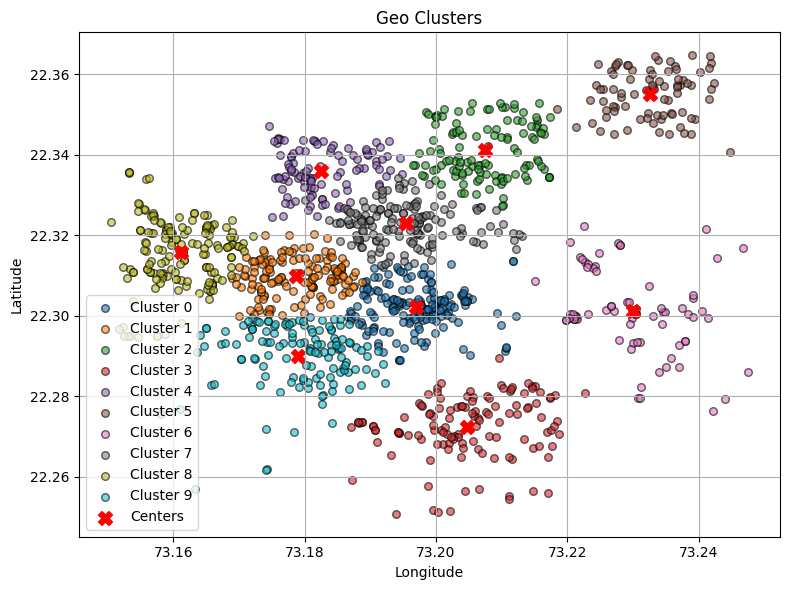

In [8]:
visualize_clusters(coordinates, cluster_labels, centers)


In [9]:
def visualize_clusters_folium(coordinates, cluster_labels, centers=None, zoom_start=12):
    avg_lat = sum([lat for _, lat in coordinates]) / len(coordinates)
    avg_lon = sum([lon for lon, _ in coordinates]) / len(coordinates)
    
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=zoom_start)
    marker_cluster = MarkerCluster().add_to(m)

    for (lon, lat), label in zip(coordinates, cluster_labels):
        color = 'gray' if label == -1 else f'#{hash(label)%0xFFFFFF:06x}'  # Random color per cluster
        popup = f"Cluster {label}" if label != -1 else "Noise"
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=popup
        ).add_to(marker_cluster)

    if centers:
        for lon, lat in centers:
            folium.Marker(
                location=[lat, lon],
                icon=folium.Icon(color='red', icon='info-sign'),
                popup='Center'
            ).add_to(m)

    return m

In [10]:
map_view = visualize_clusters_folium(coordinates, cluster_labels, centers)
map_view

In [11]:

# Predict new inputs
new_points = [(73.18, 22.3), (73.19, 22.31)]  # (lon, lat)

cluster_assignments = clusterer.predict_cluster(new_points)

In [12]:
print("Predicted clusters:", cluster_assignments)


Predicted clusters: [1 0]


In [13]:
def visualize_clusters_folium(coordinates, cluster_labels, centers, zoom_start=10):
    """
    Visualize clusters using Folium
    
    Args:
        coordinates: List of (lon, lat) tuples
        cluster_labels: List of cluster assignments
        centers: List of (lon, lat) tuples for cluster centers
        zoom_start: Initial zoom level for the map
    """
    # Create a base map
    m = folium.Map(location=[coordinates[0][1], coordinates[0][0]], zoom_start=zoom_start)
    
    # Create a color palette
    colors = [
        'red', 'blue', 'green', 'purple', 'orange', 
        'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen'
    ]
    
    # Add points to the map
    for i, (lon, lat) in enumerate(coordinates):
        cluster_idx = int(cluster_labels[i])  # Ensure cluster_idx is an integer
        if cluster_idx >= 0:  # Skip noise points if any
            color = colors[cluster_idx % len(colors)]
            folium.CircleMarker(
                location=[lat, lon],
                radius=3,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f'Cluster {cluster_idx}'
            ).add_to(m)
    
    # Add cluster centers
    for i, (center_lon, center_lat) in enumerate(centers):
        folium.Marker(
            [center_lat, center_lon],
            popup=f'Center {i}',
            icon=folium.Icon(color='black', icon='star')
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m



In [14]:
# Call the visualization function
m = visualize_clusters_folium(coordinates, cluster_labels, centers, zoom_start=10)
display(m)